In [1]:
import random
from itertools import combinations
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from icecream import ic

In [78]:
#CITIES = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])

#CITIES = pd.read_csv('cities/china.csv', header=None, names=['name', 'lat', 'lon'])

#CITIES = pd.read_csv('cities/russia.csv', header=None, names=['name', 'lat', 'lon'])

#CITIES = pd.read_csv('cities/us.csv', header=None, names=['name', 'lat', 'lon'])

CITIES = pd.read_csv('cities/vanuatu.csv', header=None, names=['name', 'lat', 'lon'])

In [79]:
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    # For each pair (c1, c2), the code calculates the geodesic distance between their geographical 
    # coordinates using geopy.distance.geodesic(), which computes the shortest path over the Earth's surface.
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km        #converts the calculated distance to kilometers

#### Setting initial population and cost function

In [80]:
# Generate initial population of paths
# each individual is a valid TSP path represented by a sequence of cities ending back at the starting city, 0.
def initial_population(pop_size, n_cities):
    start_city = 0  # Define the starting city index, all the individuals in the population MUST have the same!
    return [
        [start_city] + random.sample(range(1, n_cities), n_cities - 1) + [start_city] 
        for _ in range(pop_size)
    ]

# [0] is appended to the end of each sequence to enforce a circular route, ensuring each path returns to the starting city (index 0).

In [81]:
# Calculate cost of TSP route
def tsp_cost(tsp):
    return sum(DIST_MATRIX[tsp[i], tsp[i+1]] for i in range(len(tsp) - 1))

#### Setting mutation algorithms

In [82]:
# Mutation functions ensuring circular path
def swap_mutation(path):
    # from the range of valid indices (excluding the first and last indices, which are fixed as the starting city)
    i, j = random.sample(range(1, len(path) - 1), 2)
    path[i], path[j] = path[j], path[i]
    path[-1] = path[0]
    return path

In [83]:
def scramble_mutation(path, num_selected=5):
    # Ensure num_selected is at least 2 and does not exceed the number of cities minus 2
    num_selected = max(2, min(num_selected, len(path) - 2))
    
    # Randomly select num_selected distinct indices from the valid range
    selected_indices = random.sample(range(1, len(path) - 1), num_selected)

    # Extract the elements at the selected indices
    elements_to_scramble = [path[i] for i in selected_indices]

    # Shuffle only the selected elements
    random.shuffle(elements_to_scramble)

    # Place the shuffled elements back into their respective positions in the path
    for i, index in zip(elements_to_scramble, selected_indices):
        path[index] = i

    # Ensure the path remains circular
    path[-1] = path[0]
    
    return path

In [84]:
def insert_mutation(path, num_selected=5):
    # Always select 2 distinct indices from the valid range
    selected_indices = random.sample(range(1, len(path) - 1), 2)

    # Sort the selected indices to work with them in order
    selected_indices.sort()

    # Get the indices
    first_index = selected_indices[0]
    second_index = selected_indices[1]

    # Get the element to insert (from the second index)
    element_to_insert = path[second_index]

    # Remove the element to insert from its original position
    path.pop(second_index)

    # Insert the element right after the first index
    path.insert(first_index + 1, element_to_insert)
    
    path[-1] = path[0]  # Ensure the path remains circular
    return path

In [85]:
def inversion_mutation(path):
    i, j = sorted(random.sample(range(1, len(path) - 1), 2))
    path[i:j+1] = reversed(path[i:j+1])
    path[-1] = path[0]
    return path

#### Setting crossover algorithms

In [86]:
def cycle_crossover(parent1, parent2):
    # Ensure the length of parents is the same
    assert len(parent1) == len(parent2)

    # Trimmed versions of the parents (exclude the first and last elements for a circular route)
    trimmed_parent1 = parent1[1:-1]
    trimmed_parent2 = parent2[1:-1]
    n = len(trimmed_parent1)

    # Choose two loci within the trimmed segment
    l1, l2 = sorted(random.sample(range(n), 2))

    # Start creating offspring by copying a segment from parent1
    trimmed_offspring = [None] * n
    trimmed_offspring[l1:l2 + 1] = trimmed_parent1[l1:l2 + 1]       #l1 to l2, inclusive

    # Fill the remaining values from parent2
    current_index = 0

    # Fill with unused values from trimmed_parent2
    for city in trimmed_parent2:
        if city not in trimmed_offspring:
            # Find the next available None position in trimmed_offspring
            while trimmed_offspring[current_index] is not None:
                current_index = (current_index + 1) % len(trimmed_offspring)  # Wrap around to the start if at the end
            # Place the city in the first available None spot
            trimmed_offspring[current_index] = city
            current_index = (current_index + 1) % len(trimmed_offspring)  # Move to the next position

    # Add the fixed start and end points to form a valid TSP route
    offspring = [parent1[0]] + trimmed_offspring + [parent1[0]]

    return offspring


#### Genetic Algorithm

In [87]:
""" Pick up 1/5 of the population, select the fittest 10, if possible. """

# Parent selection using tournament selection
def tournament_selection(population, costs, tournament_size=None, num_to_return=10):
    # Determine the tournament size as 1/5 of the population
    if tournament_size is None:
        tournament_size = max(1, len(population) // 5)  # Ensure at least one individual is sampled

    # Randomly sample individuals
    selected = random.sample(list(zip(population, costs)), tournament_size)

    # Sort selected individuals by their costs
    selected_sorted = sorted(selected, key=lambda x: x[1])  # Sort by cost (x[1] is the cost)

    # Return the top 'num_to_return' individuals with the lowest costs
    return [ind[0] for ind in selected_sorted[:num_to_return]]

In [88]:
# Main Genetic Algorithm
def genetic_algorithm(cities, population_size, generations, mutation_rate=0.5):
    population = initial_population(population_size, len(cities))
    best_cost_history = []  # To store the best cost for each generation
    
    for generation in tqdm(range(generations)):
        costs = [tsp_cost(ind) for ind in population]
        best_cost_history.append(min(costs))  # Record the best cost of this generation
        
        # Parent selection: Pick 1/5 of the population and select the fittest 10
        selected_parents = tournament_selection(population, costs)

        # Generate new offspring
        offspring = []

        while len(offspring) < population_size / 2:  # Create the new population size
            # Randomly select two parents from the selected parents
            parent1 = random.choice(selected_parents)
            parent2 = random.choice(selected_parents)

            # Perform cycle_crossover to produce new individuals
            child = cycle_crossover(parent1, parent2)

            # Apply mutation based on mutation rate
            if random.random() < mutation_rate:
                # Randomly choose a mutation type to apply
                mutation_type = random.choice([inversion_mutation, insert_mutation, scramble_mutation, swap_mutation])
                child = mutation_type(child)

            offspring.append(child)

        # Combine current population with the new offspring
        combined_population = population + offspring

        # steady state approach: combine the offspring with the current population
        # Select individuals with the minimum TSP cost to survive
        combined_costs = [tsp_cost(ind) for ind in combined_population]
        sorted_population = sorted(zip(combined_population, combined_costs), key=lambda x: x[1])

        # only the individuals with the min tsp cost survive, cut off the other individuals
        # Update population to keep only the best individuals
        population = [ind[0] for ind in sorted_population[:population_size]]
        

    return population[0], tsp_cost(population[0]), best_cost_history  # Return final population and the best cost history

#### Plot results

In [89]:
def plot_best_cost(best_cost_history):
    plt.plot(best_cost_history, marker='o')
    plt.title('Best TSP Cost Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Best TSP Cost')
    plt.grid()
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

Total Cost (km): 1345.5449564733112
Total Steps (generations): 50


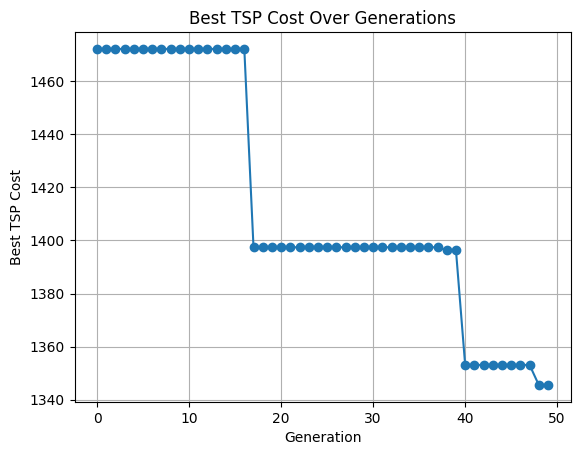

In [99]:
GENERATIONS = 50
POPULATION_SIZE = 10

last_path, total_cost, best_cost_history = genetic_algorithm(CITIES, POPULATION_SIZE, GENERATIONS)
#print("Last Path:", last_path)
print("Total Cost (km):", total_cost)
print("Total Steps (generations):", GENERATIONS)
plot_best_cost(best_cost_history)


In [102]:
def plot_tsp_path(cities_df, path):
    # Extract coordinates of cities based on their index
    x = cities_df['lon'].iloc[path].values  # Get longitudes
    y = cities_df['lat'].iloc[path].values   # Get latitudes

    # Close the loop by adding the starting city again
    x = list(x) + [x[0]]  # Add starting city again to close the loop
    y = list(y) + [y[0]]  # Add starting city again to close the loop

    plt.figure(figsize=(20, 20))
    plt.plot(x, y, marker='o')
    plt.title('Traveling Salesman Problem Path')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()

    # Annotate the cities with their names
    for i, (x_pos, y_pos) in zip(path, zip(x, y)):
        plt.annotate(cities_df['name'].iloc[i], (x_pos, y_pos), textcoords="offset points", xytext=(0,10), ha='center')

    plt.show()

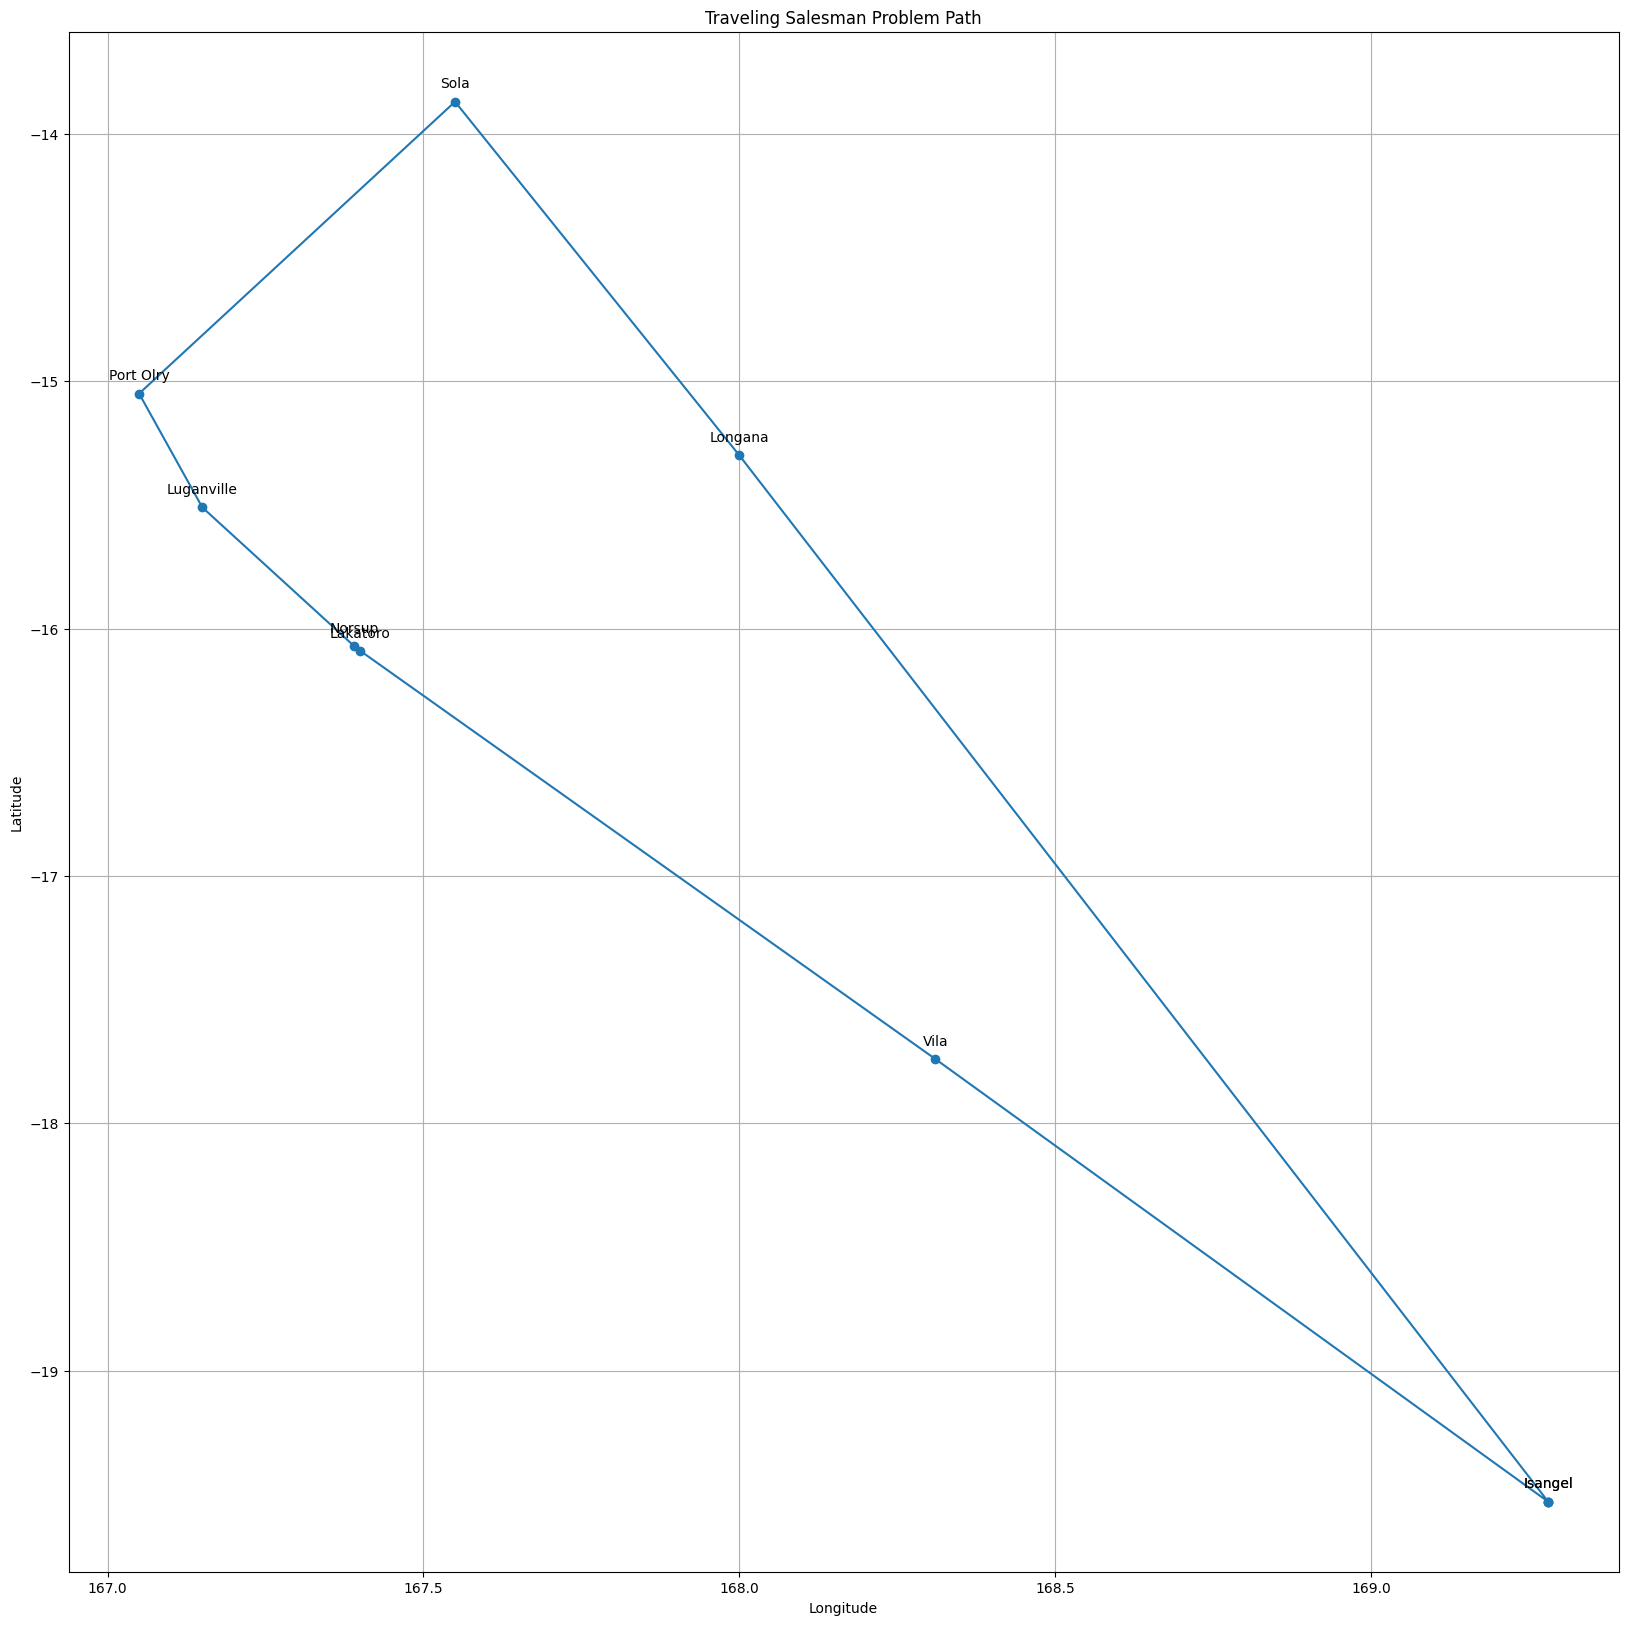

In [103]:
plot_tsp_path(CITIES, last_path)